In [1]:
import pydicom as dicom
import matplotlib.pylab as plt
import numpy as np
import os
import skimage as ski
from skimage.transform import warp, AffineTransform, pyramid_expand, pyramid_reduce
import cv2
import scipy
from natsort import natsorted
from sklearn.mixture import GaussianMixture
from skimage.registration import phase_cross_correlation
from scipy import ndimage as scp
from tqdm import tqdm
from skimage.metrics import normalized_root_mse as nrm
from statsmodels.tsa.stattools import acf
import pickle
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.fftpack import fft2, fftshift, ifft2, fft, ifft
import time
import math
from skimage.exposure import equalize_hist
from skimage.exposure import equalize_adapthist
from skimage.feature import SIFT, match_descriptors,plot_matches
from skimage.feature import ORB

import ants.registration as ants_register
import ants
from scipy.optimize import minimize as minz
from itertools import permutations 
from skimage.filters import threshold_otsu
from skimage.metrics import normalized_mutual_information as nmi
from skimage.metrics import mean_squared_error as mse
from tifffile import imread as tiffread

In [10]:
def load_data(path_num,path_all = False):
    # if (path_num==0) or (path_num=='before'):
    #     path = 'rgb/before/'
    # elif (path_num==1) or (path_num=='after'):
    #     path = 'rgb/after/'
    # elif (path_num==2) or (path_num=='after_2min'):
    if path_all:
        path = path_all
    else:
        path = f'volume_data/Hadiya_10_15_2024_Timelapse/registered/{path_num}/'
    pic_paths = []
    for i in os.listdir(path):
        if i.endswith('.dcm') or  i.endswith('.tiff') or i.endswith('.PNG'):
            pic_paths.append(i)
    pic_paths = natsorted(pic_paths)

    temp_img = cv2.imread(path+pic_paths[0],cv2.IMREAD_UNCHANGED) 
    imgs_from_folder = np.zeros((len(pic_paths),temp_img.shape[0],temp_img.shape[1]))
    # imgs_from_folder = []
    for i,j in enumerate(pic_paths):
        aa = cv2.imread(path+j,cv2.IMREAD_UNCHANGED)
        imgs_from_folder[i] = aa.copy()
    imgs_from_folder = imgs_from_folder.astype(np.float32)
    return imgs_from_folder

In [249]:
# pics_without_line = np.array(tiffread('volume_data/Hadiya_10_15_2024_Timelapse/scan22_nerve/Mediamstack_3D.tif')).astype(np.float32)
pics_without_line = np.array(tiffread('Bifocal registration/Median_3D_scan11_Patrice.tif')).astype(np.float32)

KeyboardInterrupt: 

In [227]:
n = pics_without_line.shape[1]
nn = []
for i in range(pics_without_line.shape[0]):
    nn.append(np.argmax(np.sum(pics_without_line[i][:n//2],axis=1)))

In [228]:
UP, DOWN = np.min(nn)-30,np.max(nn)+30

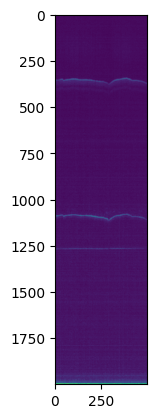

In [211]:
plt.imshow(pics_without_line.transpose(2,1,0)[300])

In [212]:
# UP, DOWN = 1050,1150

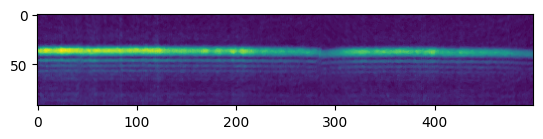

In [236]:
plt.imshow(pics_without_line.transpose(2,1,0)[100][UP:DOWN])

# Y-Motion

In [6]:
def min_max(data1):
    if np.all(data1 == data1[0]):
        return data1
    else:
        data1 = (data1-np.min(data1))/(np.max(data1)-np.min(data1))
        return data1

# def cell_extract(data_batch,n):
#     temp_data = data_batch[220:320].copy()
#     ccrds = []
#     # x_rm,y_rm = np.unravel_index(np.argmax(temp_data),temp_data.shape)
#     # ccrds.append((x_rm,y_rm))
#     for _ in range(n):
#         x_rm,y_rm = np.unravel_index(np.argmax(temp_data),temp_data.shape)
#         if x_rm<40:
#             x_rm = 0
#         if y_rm<40:
#             y_rm = 0
#         temp_data[x_rm-40:x_rm+40,y_rm-40:y_rm+40] = 0
#         ccrds.append([x_rm,y_rm])
#     ccrds = np.array(ccrds)
#     ccrds[ccrds<40] = 40
#     return ccrds

# def compare_masks(masks_extracted,data_3_n,data_3_i):
#     errs = []
#     for i in range(masks_extracted.shape[0]):
#         rr = masks_extracted[i]
#         metrics = phase_cross_correlation(data_3_n[220:320][rr[0]-40:rr[0]+40,rr[1]-40:rr[1]+40],
#                                             data_3_i[220:320][rr[0]-40:rr[0]+40,rr[1]-40:rr[1]+40],
#                                             normalization=None,upsample_factor=20)
#         errs.append(metrics[2])
#     errs_idx = np.argmin(np.abs(np.array(errs)))
#     # print(errs_idx)
#     return masks_extracted[errs_idx]
    

def div3(data):
    for i in tqdm(range(0,data.shape[0],3)):
        data[i:i+3] = phase(data[i:i+3])

    for i in tqdm(range(3,data.shape[0],3)):
        data[i:i+3] = phase_join_chunks(data[:i],data[i:i+3])
    return data

def phase(data,dis=False):
    n = data.shape[0]//2
    for i in range(data.shape[0]):
        coords = phase_cross_correlation(data[n][UP:DOWN]
                                        ,data[i][UP:DOWN]
                                        ,normalization=None,upsample_factor=20)[0]
        data[i] = scp.shift(data[i],shift = (coords[0],0),mode='constant',order=3)
    return data

def phase_join_chunks(first,second):
    coords = phase_cross_correlation(first[-1][UP:DOWN]
                                    ,second[0][UP:DOWN]
                                    ,normalization=None,upsample_factor=20)[0]
    for i in range(len(second)):
        second[i] = scp.shift(second[i],shift = (coords[0],0),mode='constant',order=3)
    return second


def div3_reg_optz(data):
    for i in tqdm(range(0,data.shape[0],3)):
        data[i:i+3] = man_reg(data[i:i+3])

    for i in tqdm(range(3,data.shape[0],3)):
        data[i:i+3] = man_join_chunks(data[:i],data[i:i+3])
    return data    

def mse_fun_tran(shif,x,y):
    tform = AffineTransform(translation=(0,shif[0]))
    warped = warp(x, tform,order=3)
    return -nmi(y,warped)
    # return mse(y,warped)

def upsamp(data,n):
    temp_data = data.copy()
    temp_data = pyramid_expand(temp_data,upscale=n,mode='constant', cval=0,order=3)
    return temp_data

def downsamp(data,n):
    temp_data = data.copy()
    temp_data = pyramid_reduce(temp_data,downscale=n,mode='constant', cval=0,order=3)
    return temp_data

def samp(data,n):
    if n>1:
        return upsamp(data,n)
    if n<1:
        return downsamp(data,np.abs(math.log(n,2)*2))
    if n==1:
        return data

def man_reg(data):
    n = data.shape[0]//2
    # get_masks = cell_extract(data[1],4)
    for i in range(data.shape[0]):
        tform2 = AffineTransform(translation=(0,0))
        if i!=n:
            # best_mask = compare_masks(get_masks,data[n],data[i])
            temp_i_data = data[i].copy()
            for pyr in [2,2,2,4,4]:
                move = (minz(method='powell',fun = mse_fun_tran,x0 =(0),
                        args = (samp((temp_i_data[220:320,100:200]),pyr)
                                ,samp((data[n][220:320,100:200]),pyr)))['x'])/pyr
                temp_transform = AffineTransform(translation=(0,move[0]))
                temp_i_data = warp(temp_i_data, temp_transform,order=3)
                tform2 = np.dot(tform2,temp_transform)
                # print('iter',pyr,mse(data[i], warp(data[i], tform2,order=3)))
            tform2 = AffineTransform(matrix = tform2)
            data[i] = warp(data[i], tform2,order=3)
            # print('done')
    return data

def man_join_chunks(first,second):
    # get_masks = cell_extract(first[-1],4)
    # best_mask = compare_masks(get_masks,first[-1],second[0])
    tform3 = AffineTransform(translation=(0,0))
    temp = second[0].copy()
    for pyr in [2]*3:
        move = (minz(method='powell',fun = mse_fun_tran,x0 =(0),
                    args = (samp((temp[220:320,100:200]),pyr)
                            ,samp((first[-1][220:320,100:200]),pyr)))['x'])/pyr
        temp_transform = AffineTransform(translation=(0,move[0]))
        temp = warp(temp, temp_transform,order=3)
        tform3 = np.dot(tform3,temp_transform)
    tform3 = AffineTransform(matrix = tform3)
    for i in range(len(second)):
        second[i] = warp(second[i], tform3,order=3)
    return second

In [231]:
# pics_without_line[:,:630] = div3(pics_without_line[:,:630])
# pics_without_line[:,np.r_[0:900,1400:1200]] = div3(pics_without_line[:,np.r_[0:600,900:1300]])

# scan 11
# pics_without_line[:,:1150] = div3(pics_without_line[:,:1150])
# pics_without_line[:,1200:] = div3(pics_without_line[:,1200:])

# scan 9
# pics_without_line[:,:1200] = div3(pics_without_line[:,:1200])
# UP, DOWN = 0,100
# pics_without_line[:,1200:] = div3(pics_without_line[:,1200:])

# scan 7
# pics_without_line[:,:1200] = div3(pics_without_line[:,:1200])

# scan 8
pics_without_line[:,:1200] = div3(pics_without_line[:,:1200])

100%|██████████| 166/166 [00:23<00:00,  7.10it/s]


In [232]:

def ants_reg_mapping(stat,mov):
    ants1 = ants.from_numpy(stat.astype(np.float32))
    ants2 = ants.from_numpy(mov.astype(np.float32))
    # mov_mask = ants.from_numpy(moving_mask.astype(np.float64))
    reg = ants_register(ants1,ants2,type_of_transform = 'Translation',aff_iterations=(1100, 1200, 1200, 1000))
    # reg_img = ants.apply_transforms(ants2, ants1, reg['fwdtransforms'])
    return reg['fwdtransforms']


def mse_fun_tran(shif,x,y):
    tform = AffineTransform(translation=(0,shif[0]))
    warped = warp(x, tform,order=3)
    return -nmi(y,warped)

In [233]:
def ants_all_trans(pics_without_line):
    transforms_all = np.tile(np.eye(3),(500,1,1))
    for i in tqdm(range(pics_without_line.shape[0]-1),desc='tr_all'):
        # tform2 = AffineTransform(translation=(0,0))
        # temp_i_data = pics_without_line[i+1].copy()
        # for pyr in [0.5,0.5,2,2,2]:
        #     move = (minz(method='powell',fun = mse_fun_tran,x0 =(0),
        #             args = (samp((temp_i_data[220:320,100:150]),pyr)
        #                     ,samp((pics_without_line[i][220:320,100:150]),pyr)))['x'])/pyr
        #     temp_transform = AffineTransform(translation=(0,move[0]))
        #     temp_i_data = warp(temp_i_data, temp_transform,order=3)
        #     tform2 = np.dot(tform2,temp_transform)

        # tform2 = AffineTransform(matrix = tform2)
        tff = AffineTransform(translation=(0,0))
        mat = scipy.io.loadmat(ants_reg_mapping(pics_without_line[i][UP:DOWN],pics_without_line[i+1][UP:DOWN])[0])
        tff = AffineTransform(translation = (0,mat['AffineTransform_float_2_2'][-2:][0][0]))
        transforms_all[i+1:] = np.dot(transforms_all[i+1:],tff)
    return transforms_all

In [234]:
# for i in tqdm(range(pics_without_line.shape[0])):
#     pics_without_line[i][:630] = warp(pics_without_line[i][:630],AffineTransform(matrix=transforms_all[i]),order=3)

# for i in tqdm(range(pics_without_line.shape[0])):
#     pics_without_line[i][np.r_[0:600,900:1300]]  = warp(pics_without_line[i][np.r_[0:600,900:1300]],AffineTransform(matrix=transforms_all[i]),order=3)

# # scan 11
# for i in tqdm(range(pics_without_line.shape[0])):
#     pics_without_line[i][:1150]  = warp(pics_without_line[i][:1150],AffineTransform(matrix=transforms_all[i]),order=3)

# # scan 9
# UP, DOWN = np.min(nn)-30,np.max(nn)+30
# tr_all = ants_all_trans(pics_without_line)
# for i in tqdm(range(pics_without_line.shape[0])):
#     pics_without_line[i][:1200]  = warp(pics_without_line[i][:1200],AffineTransform(matrix=tr_all[i]),order=3)

# # scan 7
# UP, DOWN = np.min(nn)-30,np.max(nn)+30
# tr_all = ants_all_trans(pics_without_line)
# for i in tqdm(range(pics_without_line.shape[0]),desc='warping'):
#     pics_without_line[i][:1200]  = warp(pics_without_line[i][:1200],AffineTransform(matrix=tr_all[i]),order=3)

# # scan 8
# tr_all = ants_all_trans(pics_without_line)
# for i in tqdm(range(pics_without_line.shape[0]),desc='warping'):
#     pics_without_line[i][:1200]  = warp(pics_without_line[i][:1200],AffineTransform(matrix=tr_all[i]),order=3)

# # scan 10
# tr_all = ants_all_trans(pics_without_line)
# for i in tqdm(range(pics_without_line.shape[0]),desc='warping'):
#     pics_without_line[i][:1200]  = warp(pics_without_line[i][:1200],AffineTransform(matrix=tr_all[i]),order=3)

# scan 11
tr_all = ants_all_trans(pics_without_line)
for i in tqdm(range(pics_without_line.shape[0]),desc='warping'):
    pics_without_line[i][:1200]  = warp(pics_without_line[i][:1200],AffineTransform(matrix=tr_all[i]),order=3)


warping: 100%|██████████| 500/500 [00:09<00:00, 51.75it/s]


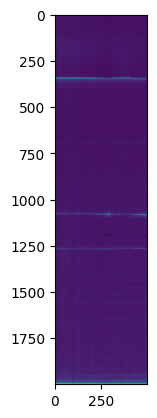

In [219]:
plt.imshow(pics_without_line.transpose(2,1,0)[100])

# X-motion

In [237]:
gg = pics_without_line.copy()

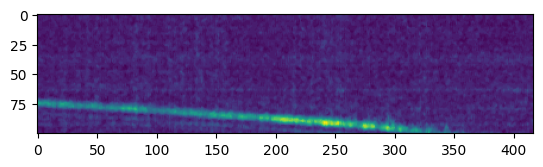

In [238]:
plt.imshow(gg[400][1000:1100])

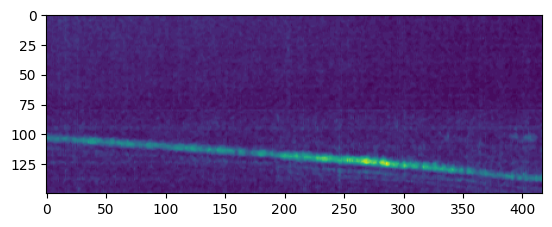

In [239]:
plt.imshow(gg[360][np.r_[220:300,1050:1120]])

In [240]:
transforms_all = np.tile(np.eye(3),(500,1,1))

# for i in tqdm(range(gg.shape[0]-1)):
#     # tff = AffineTransform(translation=(0,0))
#     mat = scipy.io.loadmat(ants_reg_mapping(gg[i][np.r_[220:300,1050:1120]],gg[i+1][np.r_[220:300,1050:1120]])[0])
#     tff = AffineTransform(translation = (mat['AffineTransform_float_2_2'][-2:][1,0],0))

#     transforms_all[i+1:] = np.dot(transforms_all[i+1:],tff)

for i in tqdm(range(gg.shape[0]-1)):
    # tff = AffineTransform(translation=(0,0))
    mat = scipy.io.loadmat(ants_reg_mapping(gg[i][1000:1100],gg[i+1][1000:1100])[0])
    tff = AffineTransform(translation = (mat['AffineTransform_float_2_2'][-2:][1,0],0))

    transforms_all[i+1:] = np.dot(transforms_all[i+1:],tff)

100%|██████████| 499/499 [02:13<00:00,  3.74it/s]


In [241]:
for i in tqdm(range(gg.shape[0])):
    gg[i] = warp(gg[i],AffineTransform(matrix=transforms_all[i]),order=3)

100%|██████████| 500/500 [00:18<00:00, 27.27it/s]


In [243]:
# os.mkdir('Bifocal registration/regis/scan11/')
for i,j in tqdm(enumerate(gg)):
    cv2.imwrite('Bifocal registration/test/'+f'frame_test{i}.PNG',(min_max(j)*255).astype(np.uint8))

500it [00:04, 105.90it/s]


# Inter Volume


In [3]:
data1 = load_data('scan16')
data2 = load_data('scan18')
data3 = load_data('scan22')

In [4]:
image1 = np.mean(data1.transpose(1,0,2)[1130:1131],axis=0)
image2 = np.mean(data2.transpose(1,0,2)[1129:1131],axis=0)
image3 = np.mean(data3.transpose(1,0,2)[1129:1131],axis=0)


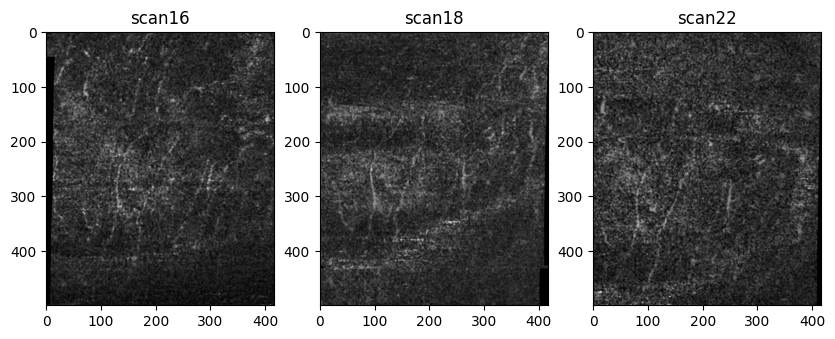

In [45]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(1,3,1)
ax1.set_title('scan16')
ax1.imshow(equalize_adapthist(min_max(image1)),cmap='gray')

ax2 = fig.add_subplot(1,3,2)
ax2.set_title('scan18')
ax2.imshow(equalize_adapthist(min_max(image2)),cmap='gray')

ax3 = fig.add_subplot(1,3,3)
ax3.set_title('scan22')
ax3.imshow(equalize_adapthist(min_max(image3)),cmap='gray')

# fig.savefig('volume_data/Hadiya_10_15_2024_Timelapse/registered/scan16_18_22.png',dpi=500)

# split correction

In [486]:
a = np.zeros((10,10))
b = np.zeros((10,10))

a[3:5,6:8] = 1
b[2:4,6:8] = 1

In [138]:
phase_cross_correlation(a,b)

(array([1., 0.]), 0.9792822626801733, 2.741291418827547e-20)

In [177]:
phase_cross_correlation(image2[:220],np.pad(image1[:200],pad_width=((0,40),(0,0))),normalization=None,upsample_factor=20)

(array([29.8 , -0.35], dtype=float32), 0.4767768877925867, 3.3256388e-06)

In [163]:
phase_cross_correlation(image2[170:],np.pad(image1[200:],pad_width=((30,0),(0,0))),normalization=None,upsample_factor=20)

(array([-30.15,  -0.1 ], dtype=float32), 0.36652110888072664, 1.2267473e-06)

In [195]:
emt = np.zeros_like((image1))
emt[:200] = warp(image1[:200],AffineTransform(translation=(-30.3,0)))
emt[200:] = warp(image1[200:],AffineTransform(translation=(30.3,0)))

In [232]:
phase_cross_correlation(image2,emt,normalization=None)

(array([23., 29.], dtype=float32), 0.38974964174618054, -1.0190544e-08)

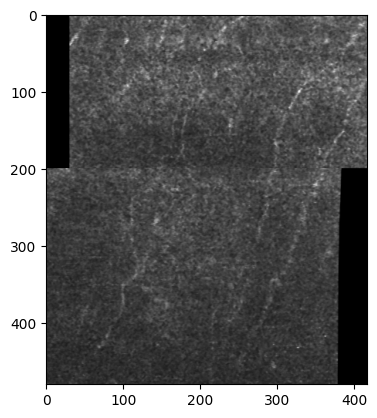

In [263]:
plt.imshow(emt[np.r_[0:200,220:500]],cmap='gray')

In [491]:
errs = []

for i in tqdm(range(data2.shape[0]-1)):
    errs.append(-nmi(data2[i][np.r_[290:400,850:925]],scan1[i+1][np.r_[290:400,850:925]]))

# for i in range(0,image1.shape[0],100):
#     errs.append(phase_cross_correlation(image1[i:i+100],image2[i:i+100],normalization=None,upsample_factor=20))

100%|██████████| 499/499 [00:02<00:00, 246.87it/s]


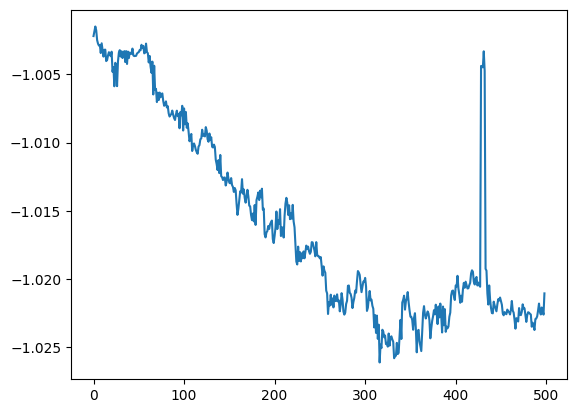

In [492]:
plt.plot(errs)

In [246]:
phase_cross_correlation(emt[:,50:-50],image2[:,50:-50],normalization=None)

(array([-24.,   2.], dtype=float32), 0.2844250703521403, 1.7906378e-07)

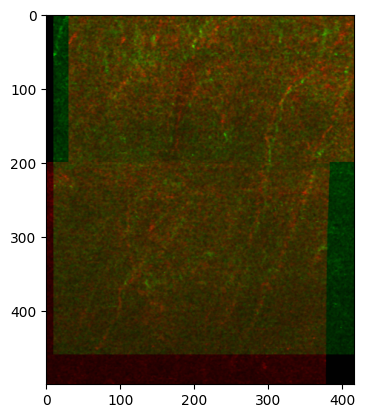

In [259]:
image1_color = np.zeros((emt.shape[0], emt.shape[1], 3), dtype=np.uint8)
image1_color[:, :, 0] = emt # Assign grayscale to the red channel

# # Color the second image in green channel
image2_color = np.zeros((image2.shape[0], image2.shape[1], 3), dtype=np.uint8)
image2_color[:, :, 1] = warp(image2,AffineTransform(translation=(-10,40))) # Assign grayscale to the green channel

# image2_unreg_color = np.zeros((image2.shape[0], image2.shape[1], 3), dtype=np.uint8)
# image2_unreg_color[:, :, 1] = image2  # Assign grayscale to the green channel
plt.imshow(cv2.addWeighted(image1_color, 5, image2_color, 5, 1).astype(np.uint8))

# blending-overlap

In [52]:
phase_cross_correlation(image1[250:350],image2[250:350],normalization=None,upsample_factor=20)

(array([ 7.9, 34.3], dtype=float32), 0.4560304426981942, 5.136072e-06)

In [537]:
# for i in range(data3.transpose(1,0,2).shape[0]):
#     data3.transpose(1,0,2)[i] = warp(data3.transpose(1,0,2)[i],AffineTransform(translation=(-50.45,35.45)))

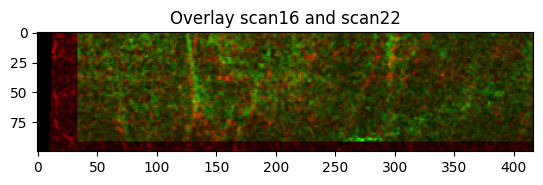

In [53]:
image1_color = np.zeros((image1[250:350].shape[0], image1[250:350].shape[1], 3), dtype=np.uint8)
image1_color[:, :, 0] = min_max(equalize_adapthist(min_max(image1[250:350])))*255 # Assign grayscale to the red channel

# # Color the second image in green channel
# image2_color = np.zeros((image2.shape[0], image2.shape[1], 3), dtype=np.uint8)
# image2_color[:, :, 1] = warp(image2,AffineTransform(translation=(-10,40))) # Assign grayscale to the green channel

image3_color = np.zeros((image3[250:350].shape[0], image3[250:350].shape[1], 3), dtype=np.uint8)
image3_color[:, :, 1] = warp(min_max(equalize_adapthist(min_max(image2[250:350]))),AffineTransform(translation=(-34,8)))*255 # Assign grayscale to the green channel

# image2_unreg_color = np.zeros((image2.shape[0], image2.shape[1], 3), dtype=np.uint8)
# image2_unreg_color[:, :, 1] = image2  # Assign grayscale to the green channel
plt.title('Overlay scan16 and scan22')
plt.imshow(cv2.addWeighted(image1_color, 1, image3_color, 1, 1).astype(np.uint8))
# plt.imsave('volume_data/Hadiya_10_15_2024_Timelapse/registered/Overlay scan16 and scan22.PNG',cv2.addWeighted(image1_color, 1, image3_color, 1, 1).astype(np.uint8),dpi=500)

In [539]:
# os.mkdir('volume_data/Hadiya_10_15_2024_Timelapse/registered/scan22_shifted_intervolume')
for i,j in tqdm(enumerate(data3)):
    cv2.imwrite('volume_data/Hadiya_10_15_2024_Timelapse/registered/scan22_shifted_intervolume/'+f'frame_test{i}.PNG',(min_max(j)*255).astype(np.uint8))

500it [00:02, 175.98it/s]


In [12]:
shifted_data = load_data(None,'volume_data/Hadiya_10_15_2024_Timelapse/registered/scan22_shifted_intervolume/')

volume_data/Hadiya_10_15_2024_Timelapse/registered/scan22_shifted_intervolume/


In [ ]:
shifted_data